# Introdução

In [1]:
# Instalação de alguns pacotes por conta da versão que vem no Google Colab
!pip install category_encoders
!pip install -U scikit-learn==0.24.2

In [2]:
# Importanto bibliotecas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Tuple
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importando os dados

In [3]:
df = pd.read_csv("/base.csv")
df.drop('Id', axis=1, inplace=True)
df.shape

(1460, 80)

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ClasseImovel          1460 non-null   int64  
 1   ClasseZona            1460 non-null   object 
 2   Fachada               1201 non-null   float64
 3   TamanhoLote           1460 non-null   int64  
 4   Rua                   1460 non-null   object 
 5   Beco                  91 non-null     object 
 6   FormaProp             1460 non-null   object 
 7   PlanoProp             1460 non-null   object 
 8   Servicos              1460 non-null   object 
 9   ConfigLote            1460 non-null   object 
 10  InclinacaoLote        1460 non-null   object 
 11  Bairro                1460 non-null   object 
 12  Estrada1              1460 non-null   object 
 13  Estrada2              1460 non-null   object 
 14  TipoHabitacao         1460 non-null   object 
 15  EstiloHabitacao      

In [81]:
df.head()

,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,Beco,FormaProp,PlanoProp,Servicos,ConfigLote,...,QualidadePiscina,QualidadeCerca,Outros,ValorOutros,MesVenda,AnoVenda,TipoVenda,CondicaoVenda,PrecoVenda,LogPrecoVenda
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109011
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317167
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849398
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429216


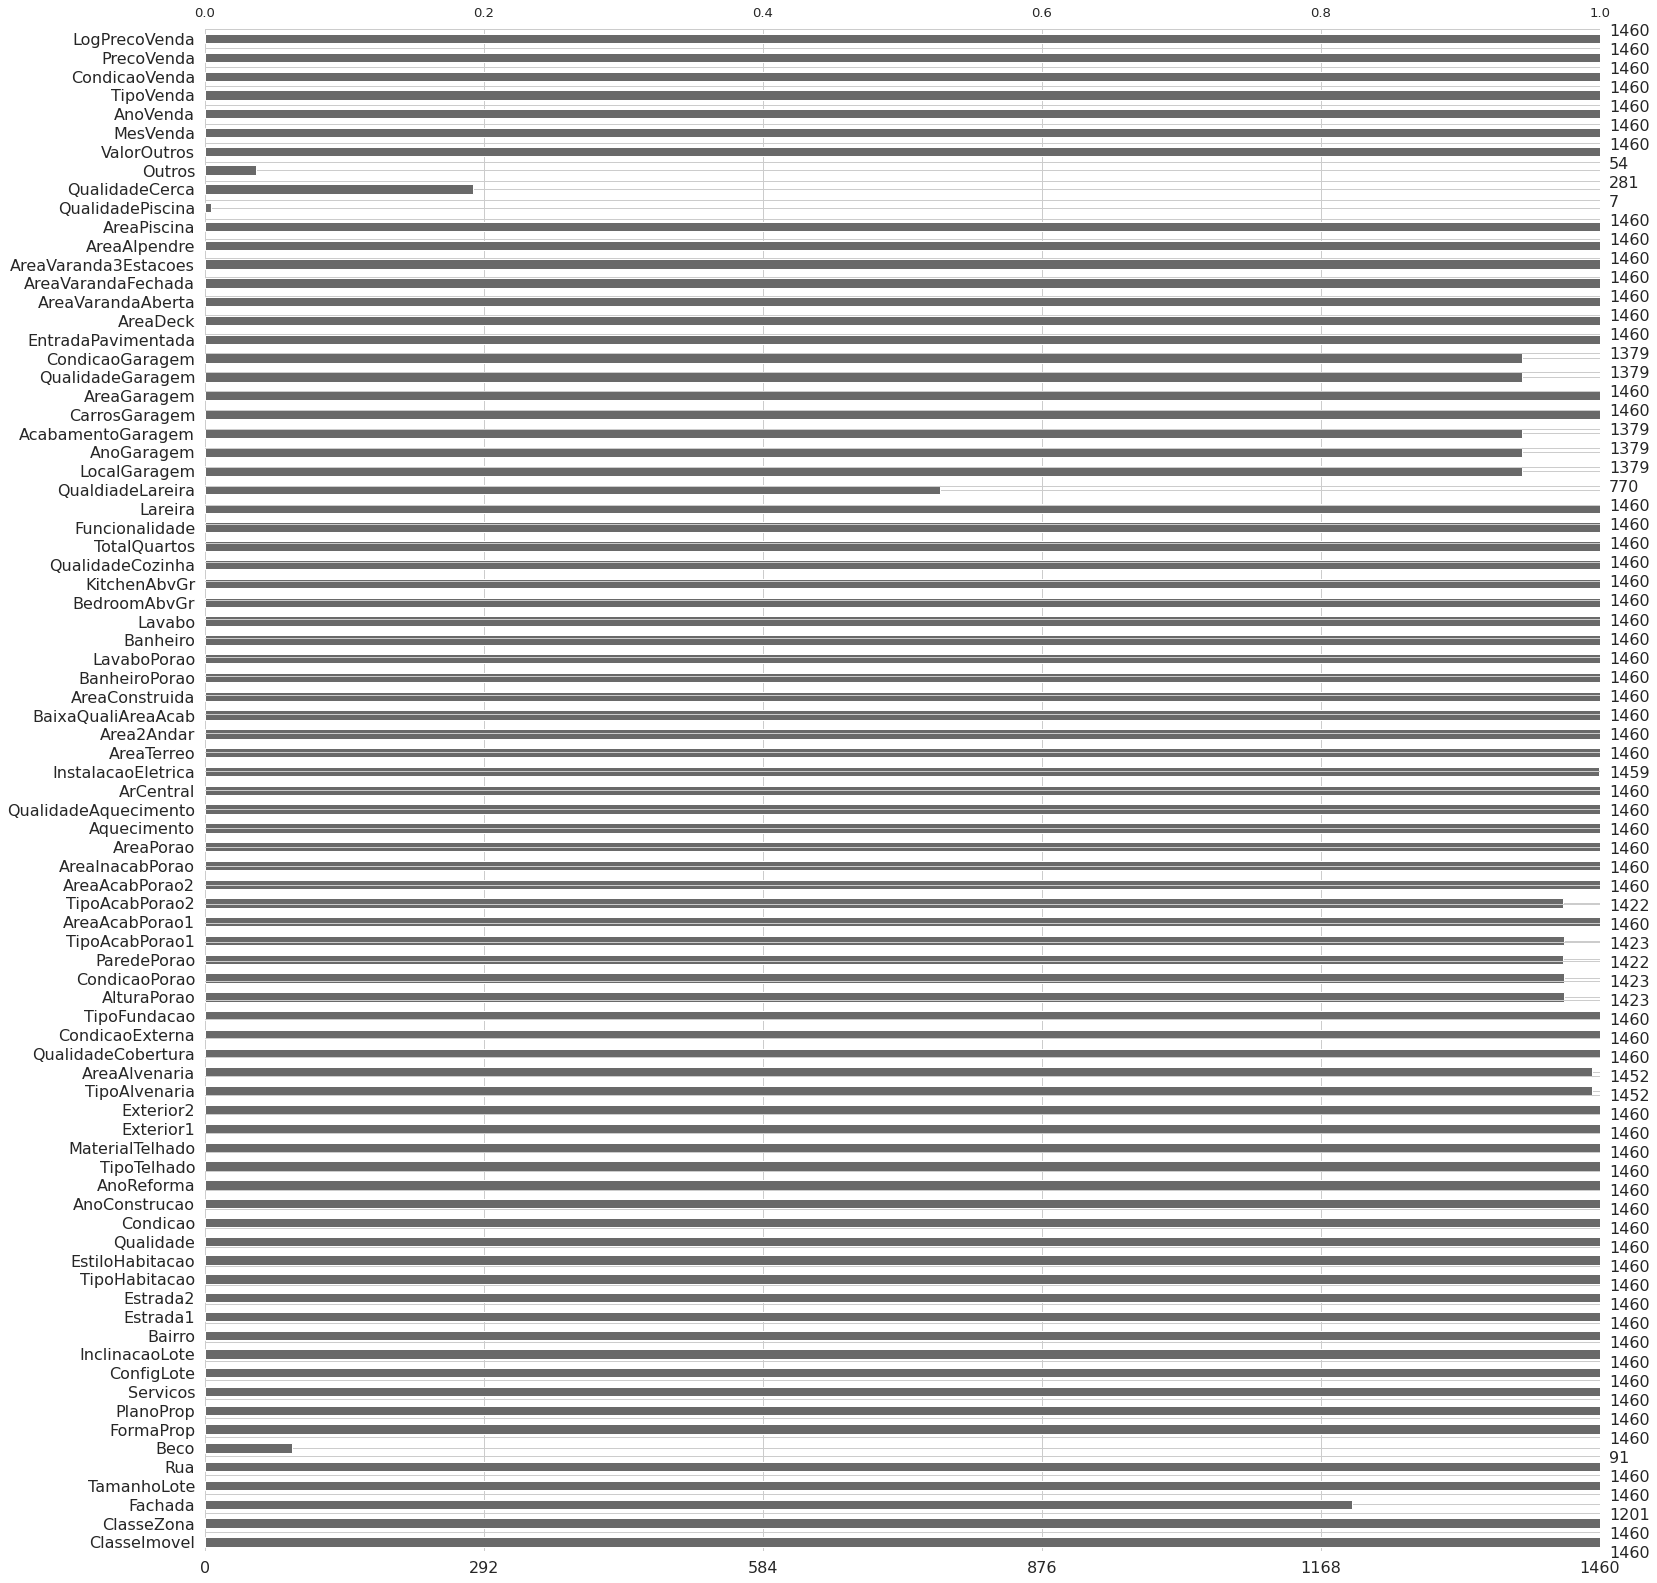

In [82]:
# Visualização de valores faltantes
import missingno as msno
msno.bar((df))
plt.show()

In [5]:
# Variável de interesse
target = 'PrecoVenda'

# Variáveis numéricas
num_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
num_vars.remove('ClasseImovel') # Apesar de ser númerica, ela é categórica
num_vars.remove(target)
print(f'Variáveis numéricas({len(num_vars)}): {num_vars}')

# Variáveis categoricas
cat_vars = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_vars.append('ClasseImovel') # É uma variável categórica
print(f'Variáveis categóricas({len(cat_vars)}): {cat_vars}')

Variáveis numéricas(35): ['Fachada', 'TamanhoLote', 'Qualidade', 'Condicao', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalQuartos', 'Lareira', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AnoVenda']
Variáveis categóricas(44): ['ClasseZona', 'Rua', 'Beco', 'FormaProp', 'PlanoProp', 'Servicos', 'ConfigLote', 'InclinacaoLote', 'Bairro', 'Estrada1', 'Estrada2', 'TipoHabitacao', 'EstiloHabitacao', 'TipoTelhado', 'MaterialTelhado', 'Exterior1', 'Exterior2', 'TipoAlvenaria', 'QualidadeCobertura', 'CondicaoExterna', 'TipoFundacao', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 'Aquecimento', 'Q

# Análise Exploratória

In [6]:
# Conferindo distribuição da variável target
df['LogPrecoVenda'] = np.log(df['PrecoVenda'].values)

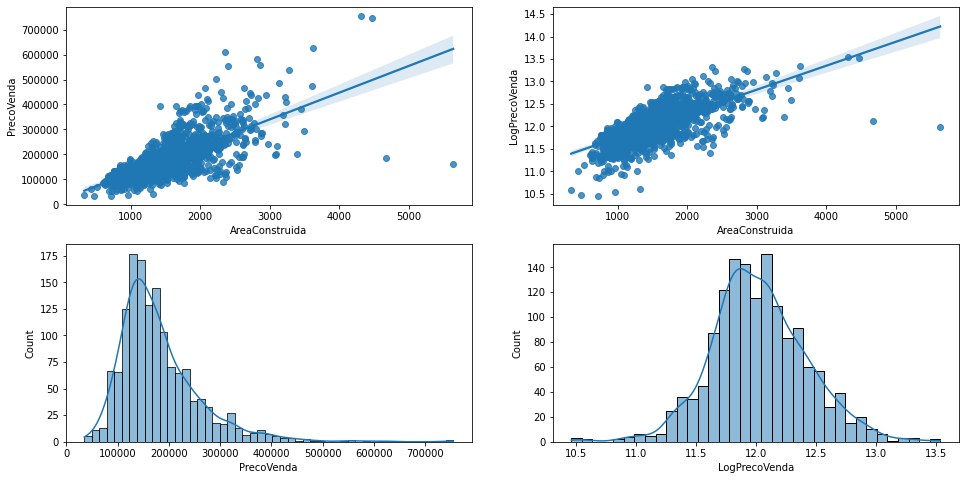

In [7]:
# Plot da distribuição do target 
fig, axs = plt.subplots(figsize=(16,8), ncols=2, nrows=2)

sns.histplot(x=df.PrecoVenda, kde=True, ax=axs[1][0])
sns.histplot(x=df.LogPrecoVenda, kde=True, ax=axs[1][1])

sns.regplot(x='AreaConstruida', y='PrecoVenda', data=df, ax=axs[0][0])
sns.regplot(x='AreaConstruida', y='LogPrecoVenda', data=df, ax=axs[0][1])

plt.show()
# A medida que a área do imovel vai aumentando, o desvio padrão vai aumentando.
# O log suaviza os valores.

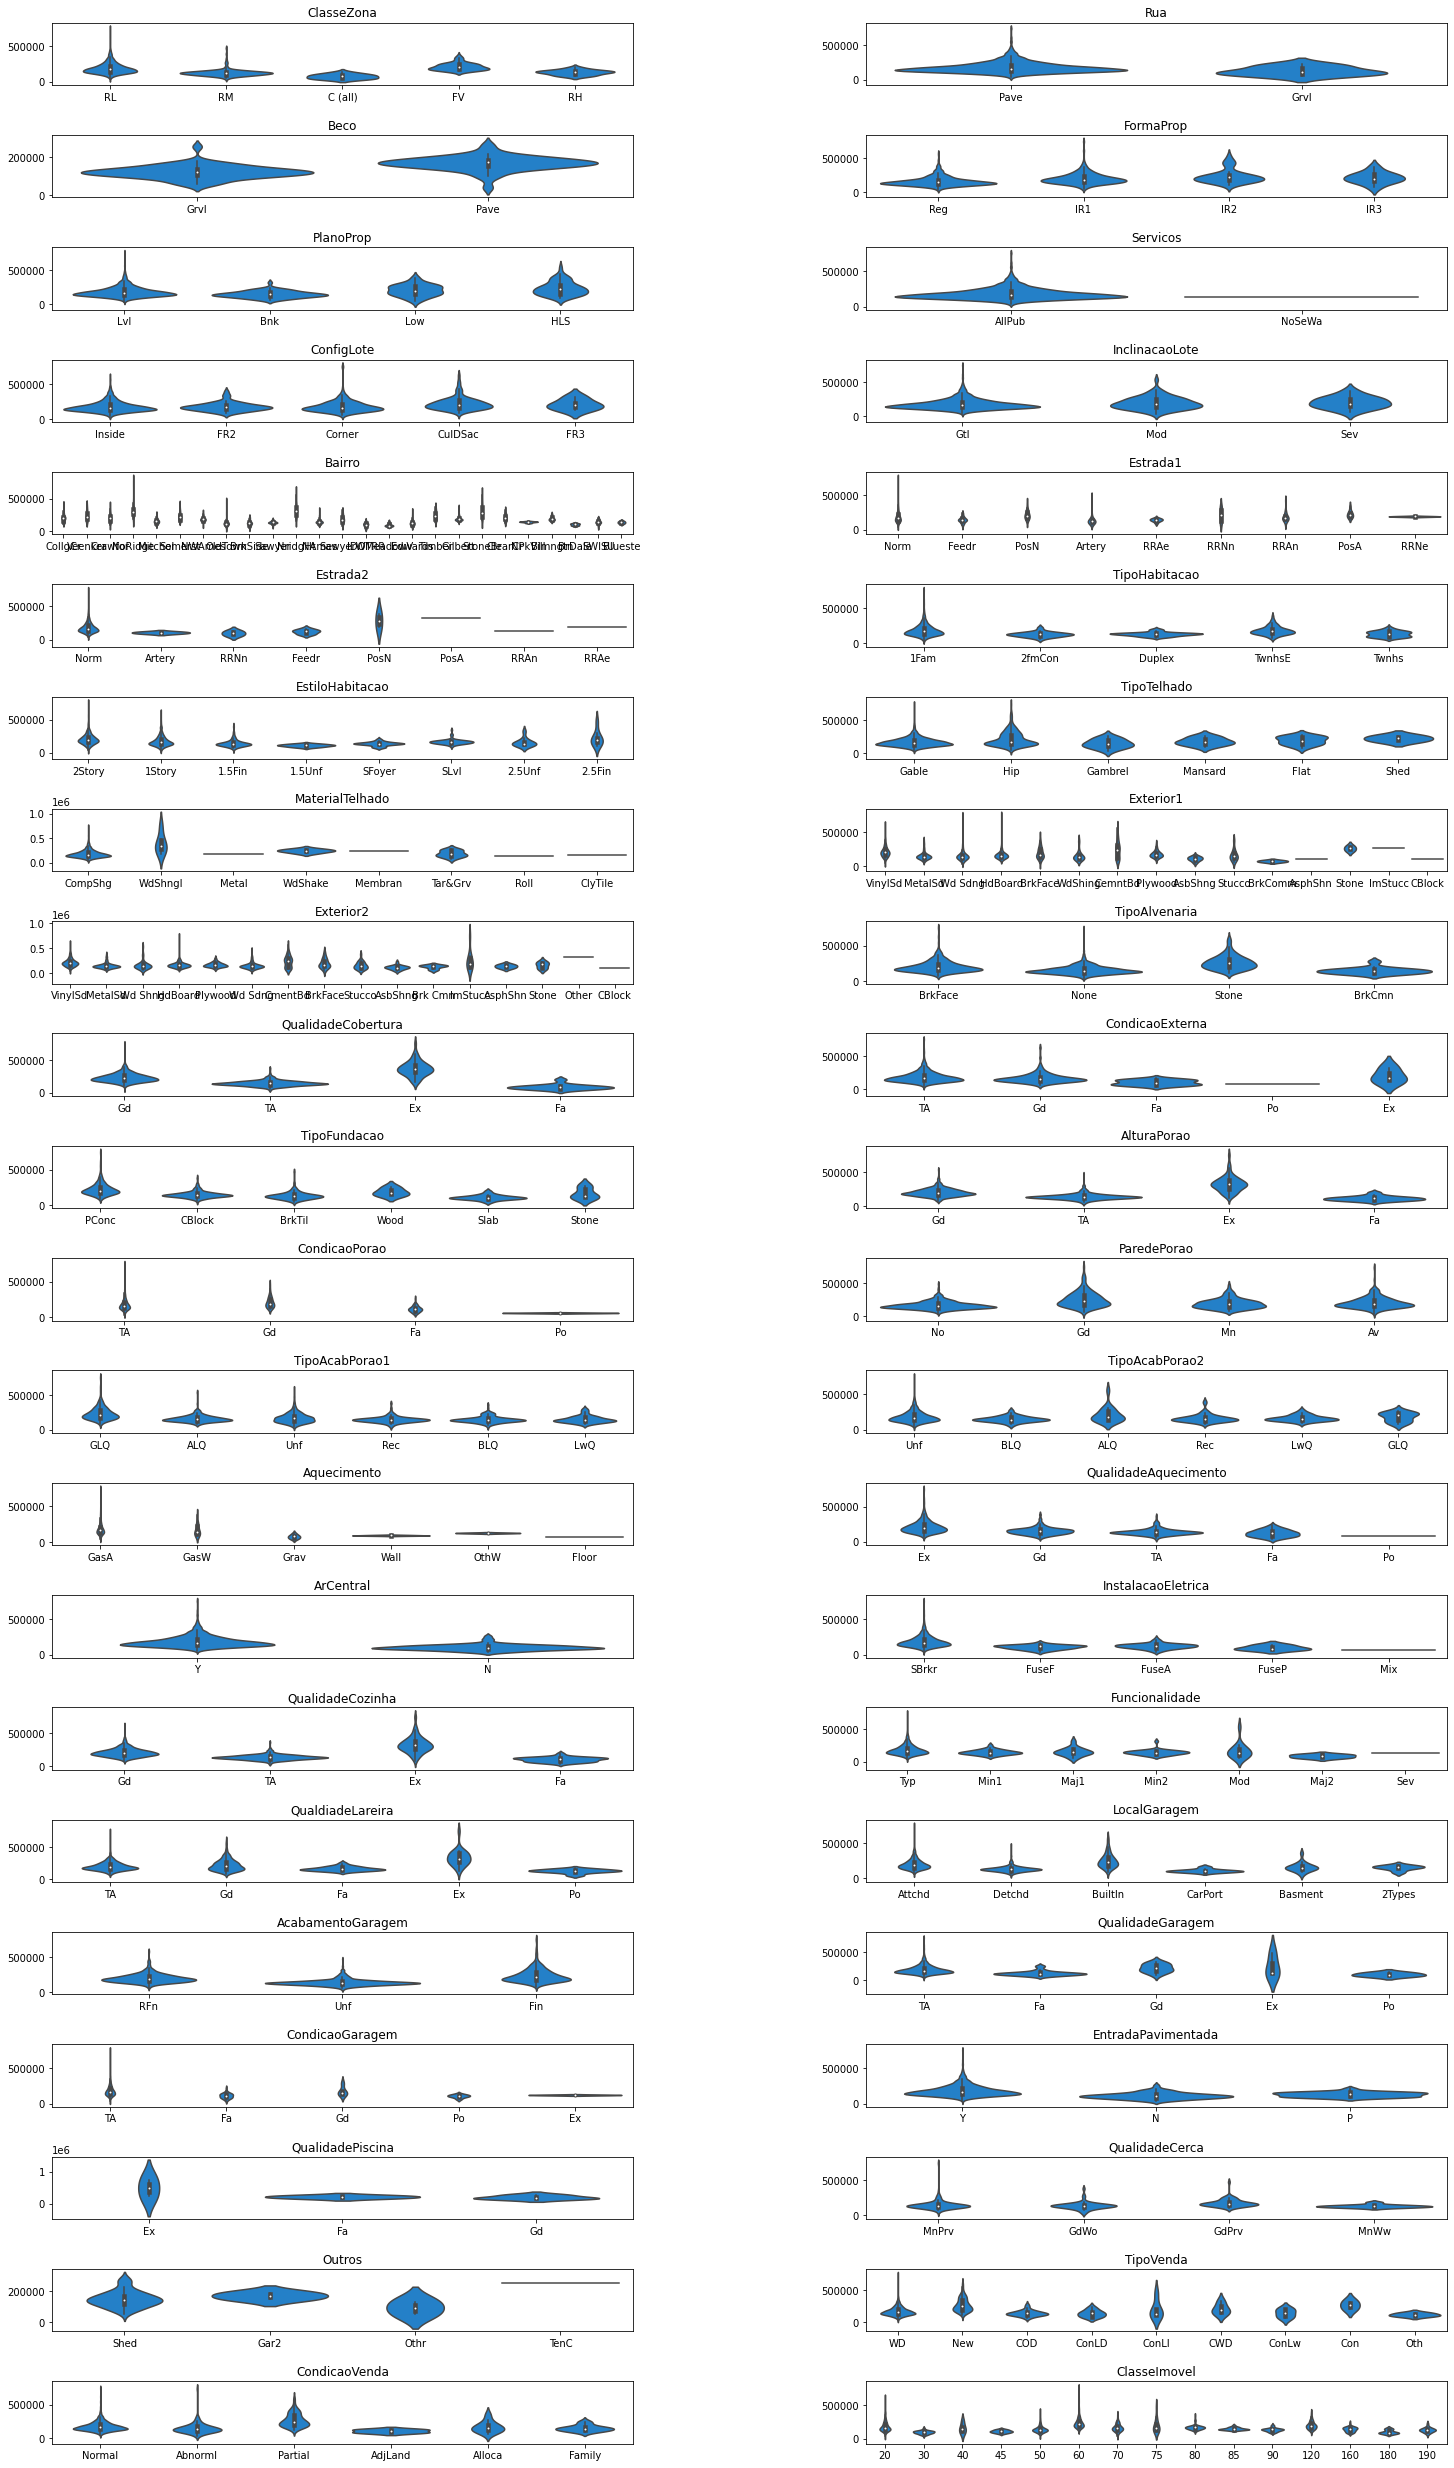

In [8]:
# Plot de todas as variavel categóricas
# Configuração da figura do matplot lib
fig = plt.figure(figsize=(25,90))
fig.subplots_adjust(hspace=0.8, wspace=0.4)

total_plots = len(cat_vars)
i = 0
# Iterando para todas variáveis categoricas
for var in cat_vars:
    # Puxando o index certo para plotar o grafico
    ax = fig.add_subplot(total_plots, 2, i+1)
    # Desenhando o gráfico do tipo violinplot
    sns.violinplot(x=var, y=target, color='#0984e3', title=var,data=df, ax=ax)
    ax.set_title(var)
    ax.set_ylabel('')
    ax.set_xlabel('')
    i += 1

plt.show()

In [9]:
# Verificando a cardinalidade das variáveis categóricas
print('Cardinalidade médias das categóricas:', np.mean(df[cat_vars].nunique()))
df[cat_vars].nunique().sort_values(ascending=False)

Cardinalidade médias das categóricas: 6.068181818181818


Bairro                  25
Exterior2               16
ClasseImovel            15
Exterior1               15
Estrada1                 9
TipoVenda                9
MaterialTelhado          8
EstiloHabitacao          8
Estrada2                 8
Funcionalidade           7
TipoAcabPorao1           6
LocalGaragem             6
TipoTelhado              6
CondicaoVenda            6
Aquecimento              6
TipoFundacao             6
TipoAcabPorao2           6
QualdiadeLareira         5
QualidadeGaragem         5
CondicaoGaragem          5
InstalacaoEletrica       5
QualidadeAquecimento     5
ClasseZona               5
ConfigLote               5
TipoHabitacao            5
CondicaoExterna          5
FormaProp                4
Outros                   4
QualidadeCerca           4
PlanoProp                4
ParedePorao              4
QualidadeCozinha         4
TipoAlvenaria            4
QualidadeCobertura       4
AlturaPorao              4
CondicaoPorao            4
InclinacaoLote           3
A

In [10]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Configura a imagem do matplot
  fig, ax = plt.subplots(figsize=size)

  # Gera um mapa de cores personalizado
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Gera uma máscara para o triângulo superio
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Desenhe o mapa de calor com a máscara e a proporção correta
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


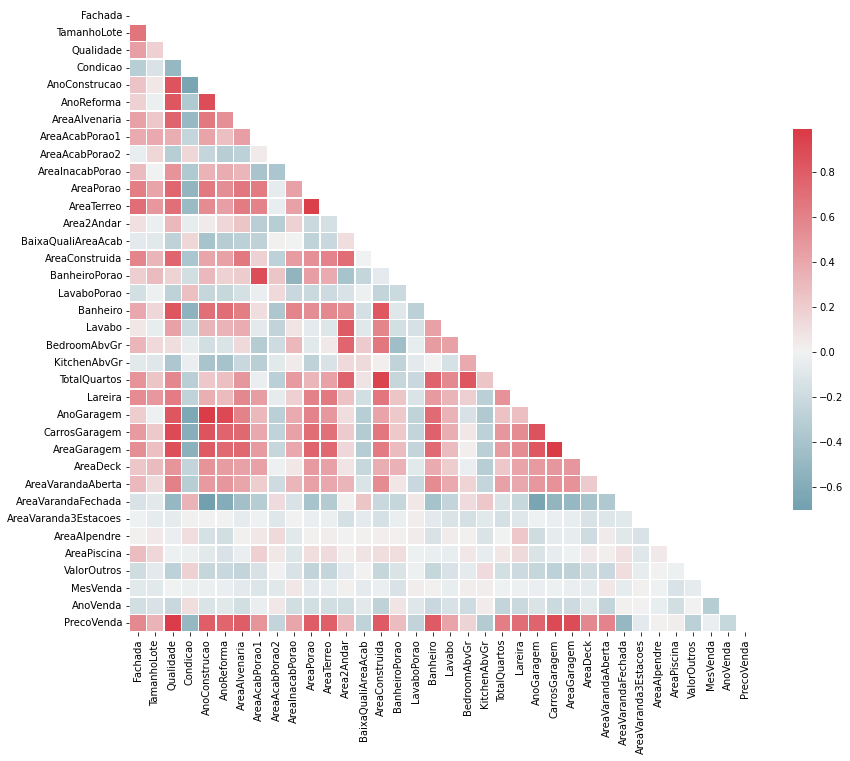

In [11]:
# Verificando a correlação entre as variáveis númericas
corr_matrix = df[num_vars + [target]].corr()
plot_corr_matrix(corr_matrix)

# Obs.: olhar a última linha (PrecoVenda) facilita o entendimento
# Buscar os pontos em que o vermelho e o azul são mais fortes, pois possuem correlação alta com o target
# Entre outras variáveis, enxergar alta colinearidade para não utilizar ambas as variáveis

In [12]:
# Correlação das variáveis númericas com a váriavel target
corr_matrix[target].sort_values(ascending=False)

PrecoVenda              1.000000
Qualidade               0.790982
AreaConstruida          0.708624
CarrosGaragem           0.640409
AreaGaragem             0.623431
AreaPorao               0.613581
AreaTerreo              0.605852
Banheiro                0.560664
TotalQuartos            0.533723
AnoConstrucao           0.522897
AnoReforma              0.507101
AnoGaragem              0.486362
AreaAlvenaria           0.477493
Lareira                 0.466929
AreaAcabPorao1          0.386420
Fachada                 0.351799
AreaDeck                0.324413
Area2Andar              0.319334
AreaVarandaAberta       0.315856
Lavabo                  0.284108
TamanhoLote             0.263843
BanheiroPorao           0.227122
AreaInacabPorao         0.214479
BedroomAbvGr            0.168213
AreaAlpendre            0.111447
AreaPiscina             0.092404
MesVenda                0.046432
AreaVaranda3Estacoes    0.044584
AreaAcabPorao2         -0.011378
LavaboPorao            -0.016844
ValorOutro

# Pré-Processamento, limpeza dos dados, construção de features

In [73]:
# Removendo algumas colunas com muitos dados faltantes, ou que não fazem sentido para a resolução do problema
# Remoção de variáveis com mais de 90% de dados faltantes
nans = df.isna().sum()
nans = nans[nans > 0]/len(df)
nans[nans > 0.90]

Beco                0.937671
QualidadePiscina    0.995205
Outros              0.963014
dtype: float64

In [74]:
cols_to_remove = ['QualidadePiscina', 'Outros', 'AnoVenda']

In [75]:
# Criando novas features
# Selecionando apenas as features de area
area_features = [var for var in num_vars if 'area' in var.lower()]

# Eleveando ao quadrado as features de área
df_area_squared = df[area_features].pow(2)
df_area_squared.columns = [var + '_squared' for var in area_features]
df_new = pd.concat([df, df_area_squared], axis=1)
print('Novos recursos quadrados: ', list(df_area_squared.columns))

# Dividino o total de alguns itens pela área construida
# Isso serve, por exemplo, para puxar uma fazenda, com área grande mas uma casa pequena
itens = ['Banheiro', 'Lavabo', 'TotalQuartos', 'Lareira', 'CarrosGaragem']
df_itens_over_area = df_new[itens].div(df_new.AreaConstruida, axis=0)
df_itens_over_area.columns = [var + '_sobreArea' for var in itens]
df_new = pd.concat([df_new, df_itens_over_area], axis=1)
print('Novos itens sobre os recursos da área: ', list(df_itens_over_area.columns))

# Removendo colunas com muitos dados faltantes
df_new.drop(cols_to_remove, axis=1, inplace=True)

# Shape do novo dataset processado
print('Shape df antigo: ', df.shape)
print('Shape df novo: ', df_new.shape)

Novos recursos quadrados:  ['AreaAlvenaria_squared', 'AreaAcabPorao1_squared', 'AreaAcabPorao2_squared', 'AreaInacabPorao_squared', 'AreaPorao_squared', 'AreaTerreo_squared', 'Area2Andar_squared', 'BaixaQualiAreaAcab_squared', 'AreaConstruida_squared', 'AreaGaragem_squared', 'AreaDeck_squared', 'AreaVarandaAberta_squared', 'AreaVarandaFechada_squared', 'AreaVaranda3Estacoes_squared', 'AreaAlpendre_squared', 'AreaPiscina_squared']
Novos itens sobre os recursos da área:  ['Banheiro_sobreArea', 'Lavabo_sobreArea', 'TotalQuartos_sobreArea', 'Lareira_sobreArea', 'CarrosGaragem_sobreArea']
Shape df antigo:  (1460, 81)
Shape df novo:  (1460, 99)


In [16]:
# Selecionando novamente as variáveis númericas e categóricas no dataset novo 
# Features numericas
num_features = df_new.select_dtypes(include=['int', 'float']).columns.tolist()
num_features.remove('ClasseImovel')
num_features.remove('LogPrecoVenda')
num_features.remove('PrecoVenda')
print(f'Features númericas({len(num_features)}): {num_features}')

# Features categoricas
cat_features = df_new.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_features.append('ClasseImovel')
df_new[cat_features] = df_new[cat_features].astype("category")
print(f'Features categóricas({len(cat_features)}): {cat_features}')

Features númericas(55): ['Fachada', 'TamanhoLote', 'Qualidade', 'Condicao', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalQuartos', 'Lareira', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AreaAlvenaria_squared', 'AreaAcabPorao1_squared', 'AreaAcabPorao2_squared', 'AreaInacabPorao_squared', 'AreaPorao_squared', 'AreaTerreo_squared', 'Area2Andar_squared', 'BaixaQualiAreaAcab_squared', 'AreaConstruida_squared', 'AreaGaragem_squared', 'AreaDeck_squared', 'AreaVarandaAberta_squared', 'AreaVarandaFechada_squared', 'AreaVaranda3Estacoes_squared', 'AreaAlpendre_squared', 'AreaPiscina_squared', 'Banheiro_sobreArea', 'Lavabo_sobreAre

# Objetivo I - Regressão Linear para interpretar

In [17]:
# Utilizando apenas exemplos onde a variável condição é igual a normal
df_lr = df_new[df_new.CondicaoVenda == 'Normal'].copy()
df_lr = pd.get_dummies(df_lr, columns=['ArCentral'], drop_first=True)

# Valores da var QualidadeCozinha:
# Ex Excelente
# Gd Bom
# TA Médio / Comum
# Fa Razoável
# Po Ruim

df_lr['QualidadeCozinha'] = df_lr['QualidadeCozinha'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
len(df_lr)

1198

In [76]:
# Função para calcular o VIF - Fator de Inflação de Variância

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):
  vif = pd.DataFrame()
  vif["variables"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

  return(vif)

#Função para plotar o VIF
def plot_vif(vif):
  print('vars: ', list(vif.columns))
  print('Fator de Inflação de Variância:', vif.VIF.sum(), '\n')


In [77]:
lr_vars = ["AreaConstruida", "CarrosGaragem", "ArCentral_Y", "AreaPorao", "Banheiro", "QualidadeCozinha"]
plot_vif(calc_vif(df_lr[lr_vars]))

vars:  ['variables', 'VIF']
Fator de Inflação de Variância: 90.16591366626693 



In [78]:
lr_vars = ["AreaConstruida", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro", "ArCentral_Y"]
plot_vif(calc_vif(df_lr[lr_vars]))

vars:  ['variables', 'VIF']
Fator de Inflação de Variância: 108.14489255540519 



In [22]:
# Fit da regressão linear

import statsmodels.api         as sm
import statsmodels.formula.api as smf

# Montando a formula da regressao linear
lr_vars = ["AreaConstruida", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro", "ArCentral_Y"]
formula ="LogPrecoVenda ~ " + ' + '.join(lr_vars)
print('Fórmula: ', formula)

# Criando o modelo de regressão linear
model = smf.ols(formula = formula, data = df_lr).fit()

# Plotando o sumario do modelo
print(model.summary())

Fórmula:  LogPrecoVenda ~ AreaConstruida + Qualidade + CarrosGaragem + AreaPorao + Banheiro + ArCentral_Y
                            OLS Regression Results                            
Dep. Variable:          LogPrecoVenda   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1139.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:48:00   Log-Likelihood:                 644.77
No. Observations:                1198   AIC:                            -1276.
Df Residuals:                    1191   BIC:                            -1240.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [23]:
# Verificando o VIF das variáveis escolhidas para compor a regressão linear
vif = calc_vif(df_lr[lr_vars])
print('Variáveis: ', lr_vars)
print('Fator de Inflação de Variância:', vif.VIF.sum(), '\n')
vif
# Obs.: academicamente VIF bom é menos de 10

Variáveis:  ['AreaConstruida', 'Qualidade', 'CarrosGaragem', 'AreaPorao', 'Banheiro', 'ArCentral_Y']
Fator de Inflação de Variância: 108.14489255540519 



,variables,VIF
0,AreaConstruida,20.561712
1,Qualidade,36.544938
2,CarrosGaragem,11.040106
3,AreaPorao,10.491630
4,Banheiro,17.210607
5,ArCentral_Y,12.295900


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


,AreaConstruida,Qualidade,CarrosGaragem,AreaPorao,Banheiro,ArCentral_Y
AreaConstruida,1.000000,0.576861,0.465061,0.383522,0.650396,0.076536
Qualidade,0.576861,1.000000,0.564465,0.494476,0.525825,0.255123
CarrosGaragem,0.465061,0.564465,1.000000,0.409797,0.452606,0.211898
AreaPorao,0.383522,0.494476,0.409797,1.000000,0.304859,0.202598
Banheiro,0.650396,0.525825,0.452606,0.304859,1.000000,0.074507
ArCentral_Y,0.076536,0.255123,0.211898,0.202598,0.074507,1.000000


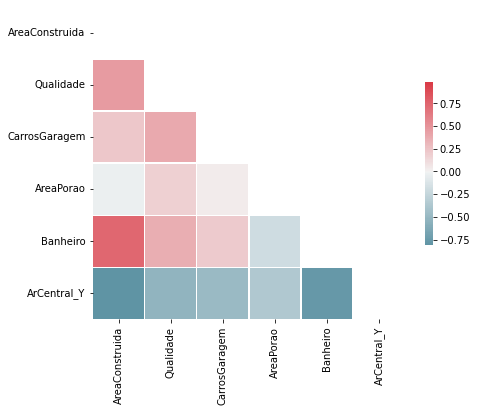

In [24]:
# Correlação das variáveis da regressão linear
corr_matrix = df_lr[lr_vars].corr()
plot_corr_matrix(df_lr[lr_vars].corr(), (7, 6))
corr_matrix
# Banheiro e área construida tem problema de multicolinariedade

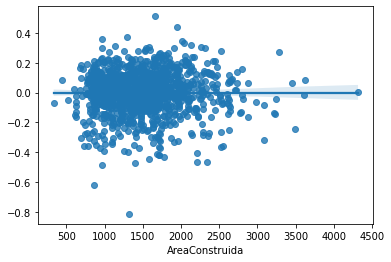

In [25]:
# Checando a Heteroscedasticidade (aumento do erro conforme aumenta a área do imóvel)
sns.regplot(x=df_lr.AreaConstruida , y=model.resid)

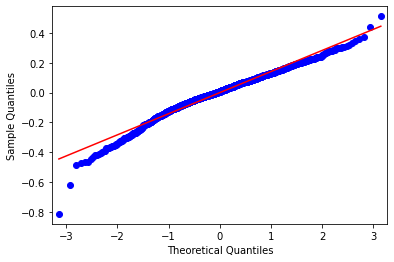

In [26]:
sm.qqplot(model.resid, line="s");
# Obs.: quanto mais próximo as duas "linhas", mais saudavel esta o modelo

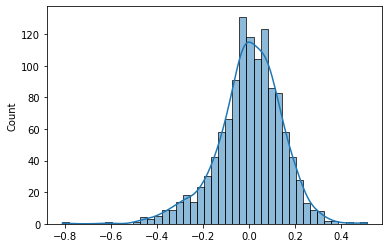

In [27]:
sns.histplot(model.resid, kde=True)

In [28]:
round((np.exp(model.params[1:]) - 1)*100, 2)

AreaConstruida     0.02
Qualidade         10.58
CarrosGaragem      9.41
AreaPorao          0.02
Banheiro           1.56
ArCentral_Y       24.58
dtype: float64

Interpretação dos coeficientes:
* AreaConstruida 0.02% - Aumento de 1 un da AreaConstruida aumenta em 0.02% o preço do imóvel
* Qualidade 10.58% - Para cada aumento do nível de qualidade, aumenta em 10.58% o preço do imóvel
* CarrosGaragem 9.41% - Aumento de 1 un de CarrosGaragem aumenta em 9.41% o preço do imóvel
* AreaPorao 0.02% - Aumento de 1 un da AreaPorao aumenta em 0.02% o preço do imóvel
* Banheiro 1.56% - Aumento de 1 un de Banheiros aumenta em 1.56% o preço do imóvel
* ArCentral_Y 24.58% - Presença de ar condicionado central aumenta 24.58% o valor do imóvel

# Objetivo II: poder preditivo, regressão por random forest

In [29]:
#Função para criar Datasets de Treino, validação e teste
def train_test_valid_split(
    df: pd.DataFrame,
    features: list,
    target: str,
    test_size: float,
    valid_size: float,
    random_state: int,
) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    
    # Primeira separação em treino e teste
    (X_train, X_test, y_train, y_test) = train_test_split(
        df[features],
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    # Segunda separação em treino e teste
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val

In [31]:
# Separação dos dados em treino e teste
features = num_features + cat_features

(
  X_train, X_test, 
  X_val, y_train, 
  y_test, y_val
) = train_test_valid_split(df_new, features=features, target=target, test_size=0.3, valid_size=0.5, random_state=42)

print('X Treino shape', X_train.shape)
print('X Validação shape', X_val.shape)
print('X Teste shape', X_test.shape)

X Treino shape (1022, 97)
X Validação shape (219, 97)
X Teste shape (219, 97)


In [32]:
# Pre-processamento dos datasets de treino, teste e validação
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer

def random_forest_preprocessing(X_train, X_val, X_test, y_train):

  # Pré-processamento das categóricas (imputador de dados faltantes)
  # Substitui um dado faltante pela moda da variável
  # Fita para o dataset de treino, e repassa para o teste e validação
  cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_val[cat_features] = cat_imputer.transform(X_val[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  # Substitui um dado nulo pela moda da variável
  cat_imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_val[cat_features] = cat_imputer.transform(X_val[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  # Pré-processamento das categóricas (codifica variaveis categóricas)
  # Agrupa em categorias e tira a média do target transformando em valores que façam sentido
  target_encoder = TargetEncoder()
  X_train[cat_features] = target_encoder.fit_transform(X_train[cat_features], y_train)
  X_val[cat_features] = target_encoder.transform(X_val[cat_features])
  X_test[cat_features] = target_encoder.transform(X_test[cat_features])

  # Pré-processamento das numericas (imputador de dados faltantes)
  # Substitui dados faltantes pela mediana da variável
  num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
  X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
  X_val[num_features] = num_imputer.transform(X_val[num_features])
  X_test[num_features] = num_imputer.transform(X_test[num_features])

  return X_train, X_val, X_test

X_train, X_val, X_test = random_forest_preprocessing(X_train.copy(), X_val.copy(), X_test.copy(), y_train)

### Fit RandomForest base

In [79]:
# Função de métricas
def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'métrica': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

In [80]:
# RandomForest é um conjunto de árvores de decisão
# É uma série de "perguntas" no qual vai criando ramificações
# Até chegar na "folha" com o target
from sklearn.ensemble import RandomForestRegressor
rf_baseline = RandomForestRegressor(random_state=42)
# Treino
rf_baseline.fit(X_train, y_train)

y_val_baseline_pred = rf_baseline.predict(X_val)
baseline_report = metrics_report(y_val, y_val_baseline_pred, 'validação')
baseline_report
# Na média, o modelo erra $28k pra cima ou pra baixo 
# O erro percentual absoluta erra 9% pra cima ou pra baixo

,métrica,validação
0,RMSE,28201.24
1,MAE,16561.61
2,R^2,0.90
3,MAPE,0.09
4,Avg. target,174313.75
5,Avg. Prediction,171594.96


## Encontrando os melhores hiperparâmetros para o RandomForest

In [38]:
# Hiperparâmetros são um conjunto de caracteristicas que você define sobre como o modelo irá funcionar
# Encontrar o melhor parametro de n° de estimadores 
for n_estimators in [10, 30, 50, 70, 100, 150, 200]:
  print(f'Random forest, com n_estimadores {n_estimators}')
  rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')
# rmse = raiz do erro quadrado médio - quanto menor, melhor

Random forest, com n_estimadores 10
rmse: 29830.096709926394

Random forest, com n_estimadores 30
rmse: 29456.04901134411

Random forest, com n_estimadores 50
rmse: 29504.202718893208

Random forest, com n_estimadores 70
rmse: 28401.53851655764

Random forest, com n_estimadores 100
rmse: 28201.241333441532

Random forest, com n_estimadores 150
rmse: 28303.09381373777

Random forest, com n_estimadores 200
rmse: 28461.653877996003



In [40]:
# 100 foi o melhor n de estimadores
# Então uma nova tentativa com números próximos a 100
for n_estimators in [90, 95, 100, 105, 110]:
  print(f'Random forest, com n_estimadores {n_estimators}')
  rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')
# 105 foi o melhor

Random forest, com n_estimadores 90
rmse: 28185.961233679554

Random forest, com n_estimadores 95
rmse: 28255.510393240238

Random forest, com n_estimadores 100
rmse: 28201.241333441532

Random forest, com n_estimadores 105
rmse: 28030.247449171333

Random forest, com n_estimadores 110
rmse: 28130.34640742328



In [43]:
# Otimizando o max_features
for max_features in ['sqrt', 0.1, 0.2, 0.3, 0.4, 0.6]:
  print(f'Random forest, com max_features {max_features}')
  rf_model = RandomForestRegressor(n_estimators=150, max_features=max_features, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')
# 0.3 foi o melhor

Random forest, com max_features sqrt
rmse: 29460.103049913483

Random forest, com max_features 0.1
rmse: 29460.103049913483

Random forest, com max_features 0.2
rmse: 28362.761607611334

Random forest, com max_features 0.3
rmse: 27113.51143598948

Random forest, com max_features 0.4
rmse: 27474.68330443565

Random forest, com max_features 0.6
rmse: 27624.867528230505



In [44]:
# Otimizando o min_samples_leaf
for min_samples_leaf in list(range(1,6)):
  print(f'Random forest, com min_samples_leaf {min_samples_leaf}')
  rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= min_samples_leaf, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')
# 1 foi o melhor

Random forest, com min_samples_leaf 1
rmse: 27113.51143598948

Random forest, com min_samples_leaf 2
rmse: 27968.612891251596

Random forest, com min_samples_leaf 3
rmse: 29346.967424662187

Random forest, com min_samples_leaf 4
rmse: 30610.774862355524

Random forest, com min_samples_leaf 5
rmse: 30706.515926828102



## RanfomForest com os melhores hiperparâmetros

In [46]:
rf_model = RandomForestRegressor(n_estimators=100, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train, y_train)
y_val_pred = rf_model.predict(X_val)
metrics_report(y_val, y_val_pred, 'validação')

,metric,validação
0,RMSE,27103.41
1,MAE,15629.03
2,R^2,0.90
3,MAPE,0.09
4,Avg. target,174313.75
5,Avg. Prediction,172064.55


## Importância das features, removendo variáveis pouco importantes

In [47]:
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
# Entende quais são as melhores features para o modelo
from sklearn.inspection import permutation_importance
print('Executando a importância do recurso de permutação...')
permutation_result = permutation_importance(rf_model, X_val, y_val, n_repeats=5, random_state=42)

Executando a importância do recurso de permutação


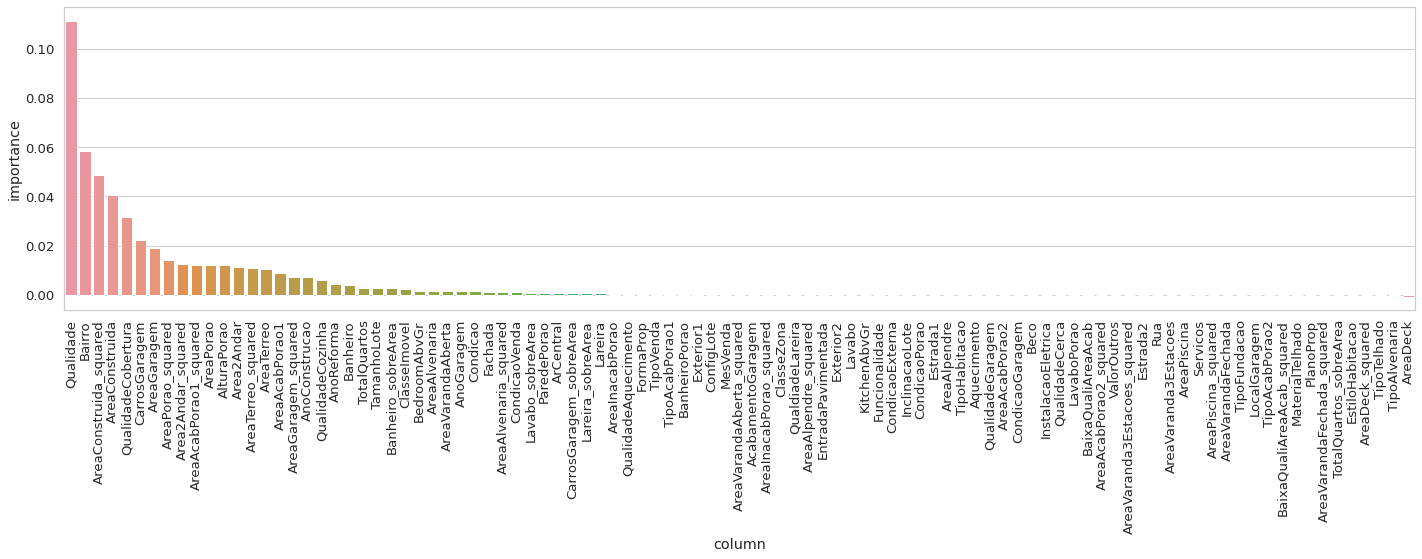

In [59]:
# Plotando o importância do feature de permutação
from sklearn.inspection import permutation_importance

importances = pd.DataFrame({'column' : X_val.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [71]:
# Pegando o top 25 melhores variaveis
best_features = importances.head(25).column.tolist()
print(best_features)

['Qualidade', 'Bairro', 'AreaConstruida', 'AreaConstruida_squared', 'QualidadeCobertura', 'AreaAcabPorao1_squared', 'CarrosGaragem', 'AreaAcabPorao1', 'TamanhoLote', 'QualidadeCozinha', 'AreaPorao', 'AlturaPorao', 'AreaPorao_squared', 'AnoConstrucao', 'AreaTerreo_squared', 'ClasseImovel', 'AreaTerreo', 'Area2Andar', 'Area2Andar_squared', 'AnoReforma', 'TotalQuartos', 'AreaGaragem_squared', 'AreaGaragem', 'Banheiro', 'Banheiro_sobreArea']


## Retreinando o RandomForest com as top 25 variáveis mais importantes

In [72]:
# Treino final do modelo de RandomForest
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train[best_features], y_train)

# Computando predições
y_train_pred = rf_model.predict(X_train[best_features])
y_val_pred = rf_model.predict(X_val[best_features])
y_test_pred = rf_model.predict(X_test[best_features])

# Calculando as métricas de performance do modelo para o treino, validação e teste
train_report = metrics_report(y_train, y_train_pred, 'treino')
val_report = metrics_report(y_val, y_val_pred, 'validação')
test_report = metrics_report(y_test, y_test_pred, 'teste')

final_report = pd.concat([train_report, val_report[['validação']],  test_report[['teste']]], axis=1)

print(f'Report do modelo base (variáveis totais: {len(features)})')
print(baseline_report)
print('')
print(f'Report do modelo final (variáveis totais: {len(best_features)})')
print(final_report)

Report do modelo base (variáveis totais: 97)
            metric  validação
0             RMSE   28201.24
1              MAE   16561.61
2              R^2       0.90
3             MAPE       0.09
4      Avg. target  174313.75
5  Avg. Prediction  171594.96

Report do modelo final (variáveis totais: 25)
            metric     treino  validação      teste
0             RMSE   11346.63   25405.04   22755.59
1              MAE    6562.42   15665.82   15202.27
2              R^2       0.98       0.92       0.92
3             MAPE       0.04       0.09       0.10
4      Avg. target  181312.69  174313.75  185701.65
5  Avg. Prediction  181044.44  172313.55  185827.28


Executando a importância do recurso de permutação com o modelo final no conjunto de teste retido


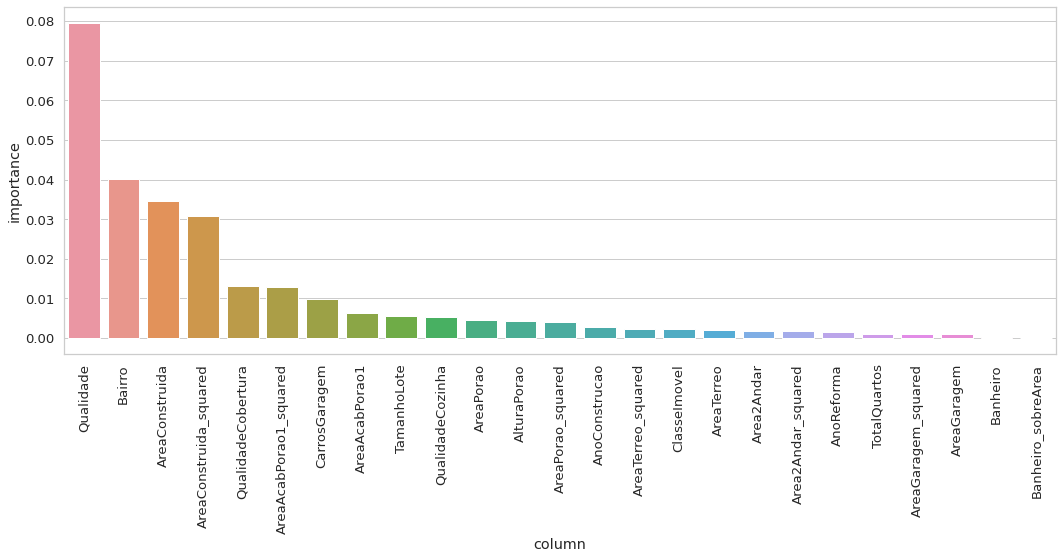

In [62]:
# Computanto a importância das features do modelo final no dataset de teste (held-out testing set)
print('Executando a importância do recurso de permutação com o modelo final no conjunto de teste retido')
permutation_result = permutation_importance(rf_model, X_test[best_features], y_test, n_repeats=5, random_state=42)

importances = pd.DataFrame({'column' : X_test[best_features].columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()